4-1. 4차원 배열

In [1]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

높이 28, 너비 28 채널 1개인 데이터 10개를 무작위로 생성

In [3]:
# 10개의 데이터 중 첫 번째 데이터에 접근
x[0].shape

(1, 28, 28)

In [4]:
# 첫 번째 데이터의 첫 채널의 공간 데이터에 접근
x[0,0].shape

(28, 28)

4-3. 합성곱 계층 구현하기

In [6]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1,3,7,7)    # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)   # 데이터 수 10개
col2 = im2col(x2, 5,5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [7]:
# 합성곱 계층 구현
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N,C,H,W = x.shape
        out_h = int(1+ (H+2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)  # 입력 데이터를 im2col로 전개
        col_W = self.W.reshape(FN, -1).T    # 필터를 2차원으로 배열로 전개
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        
        return out

4-4. 풀링 계층 구현

In [8]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N,C,H,W = x.shape
        out_h = int(1+(H-self.pool_h) / self.stride)
        out_w = int(1+(W-self.pool_w) / self.stride)
        
        # 전개 1
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 최댓값
        out = np.max(col, axis=1)
        
        # 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
        
        return out

5. CNN 구현하기

In [19]:
from collections import OrderedDict
import pickle
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    def __init__(self, input_dim = (1,28,28),
                 conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10,
                 weight_init_std = 0.01):
        
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 가중치 매개변수 초기화
        # 학습에 필요한 매개변수들을 인스턴스 변수 params에 저장
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        
        # CNN 구성 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
        
        
    # 추론 수행
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    
    # 손실 함수의 값 구하기
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y,t)
    
    
    # 오차역전파법으로 기울기 구하기
    def gradient(self, x, t):
        
        # 순전파
        self.loss(x,t)
        
        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]
    

- input_dim : 입력데이터 (채널 수 , 높이, 너비)의 차원
- conv_param : 합성곱 계층의 하이퍼파라미터
    - filter_num : 필터 수 
    - filter_size : 필터 크기
    - stride : 스트라이드
    - pad : 패딩
    - hidden_size : 은닉층(완전뉴런)의 뉴런 수
    - output_size : 출력층(완전뉴런)의 뉴런 수
    - weight_int_std : 초기화 때의 가중치 표준 편차

MNIST 데이터셋 학습

In [20]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간낭비 방지용 데이터 수 줄임
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)

trainer.train()

# 매개변수 보존
network.save_params('params.pkl')
print('Saved Network Parameters!')

train loss:2.2994802045163816
=== epoch:1, train acc:0.263, test acc:0.242 ===
train loss:2.296808903475506
train loss:2.293231484142874
train loss:2.2832260829787776
train loss:2.2714188337254924
train loss:2.263434176272049
train loss:2.243962326003319
train loss:2.2331020273055198
train loss:2.1975885264379666
train loss:2.2054042230534927
train loss:2.1295534228327155
train loss:2.1081266208704985
train loss:2.095104483729305
train loss:2.0051533975075784
train loss:1.9720037509688675
train loss:1.8488470530025949
train loss:1.8995617317158304
train loss:1.6756220735843328
train loss:1.6142098813220291
train loss:1.6141403688188785
train loss:1.465010417441571
train loss:1.3853251838781946
train loss:1.384866934773767
train loss:1.2762200526278082
train loss:1.1419657356861277
train loss:1.1092291112790194
train loss:1.0859668802358475
train loss:1.0204485527662899
train loss:0.9241893678530397
train loss:0.8618906817070038
train loss:0.8697009418514092
train loss:0.746540905000337

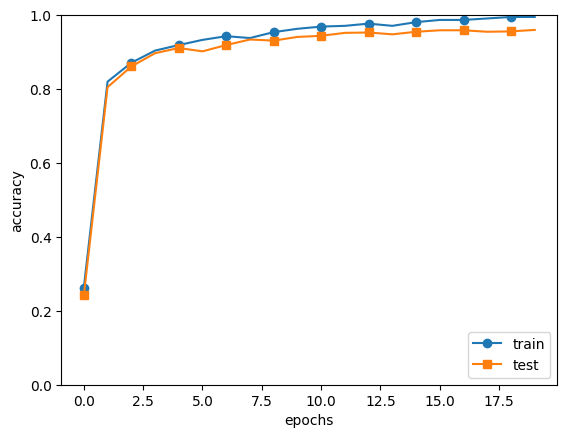

In [21]:
# 그래프 그리기
markers = {'train':'o', 'test':'s'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

6-1. 1번쨰 층의 가중치 시각화

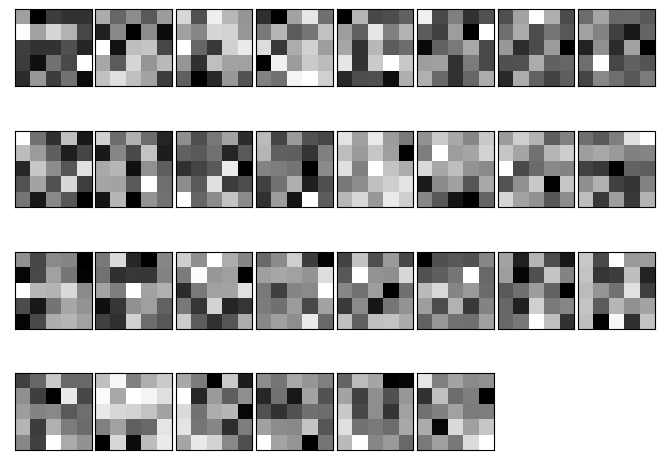

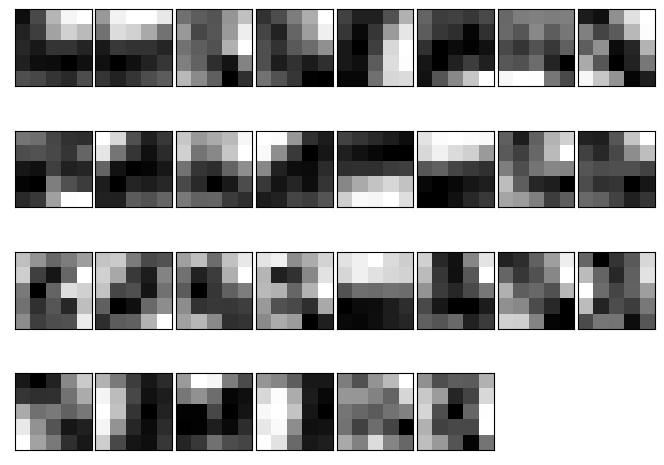

In [23]:
def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN/nx))
    
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i,0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()
    
network = SimpleConvNet()

# 랜덤 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 후의 가중치
network.load_params('params.pkl')
filter_show(network.params['W1'])

학습 전 필터는 무작위로 초기화되고 있어 흑백의 정도에 규칙성이 없음

학습을 마친 필터는 규칙성있는 이미지가됨